## Using edge extraction, and verifying its feasibility

#### First method to attempt is Canny Edge Detection
Steps involved are:
1.  Apply Gaussian filter to smooth the image in order to remove the noise
2.  Find the intensity gradients of the image (i.e. find the edges)
3.  Apply gradient magnitude thresholding or lower bound cut-off suppression to get rid of spurious response to edge detection
4.  Apply double threshold to determine potential edges
5.  Track edge by hysteresis: Finalize the detection of edges by suppressing all the other edges that are weak and not connected to strong edges.

In [2]:
import os
import numpy as np
import re
import matplotlib.pyplot as plt
import cv2
# set-up steps

[ WARN:0@0.032] global loadsave.cpp:248 findDecoder imread_('../data/C-8_40.png'): can't open/read file: check file path/integrity


TypeError: Image data of dtype object cannot be converted to float

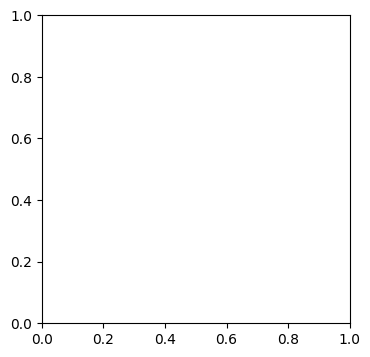

In [2]:
image = cv2.imread('../data/C-8_40.png')

plt.figure(figsize=(4,4))

plt.imshow(image, cmap='gray')
plt.title('Gray image')

In [3]:
# Step 1: Gaussian filter for blurring first
blurred = cv2.GaussianBlur(image[:,:,0], (5,5), 1)

# Step 2: Sobel Filter for edge detection (computing gradients)
gX = cv2.Sobel(blurred, cv2.CV_64F, 1, 0)
gY = cv2.Sobel(blurred, cv2.CV_64F, 0, 1)

# Calculate the magnitude
magnitude = np.sqrt((gX ** 2) + (gY ** 2))

# and the direction, may need it later
orientation = np.arctan2(gY, gX) * (180 / np.pi) % 180

TypeError: 'NoneType' object is not subscriptable

In [4]:
np.ptp(blurred)

227

In [5]:
# trying out just regular suppression
suppressed = blurred.copy()
suppressed[suppressed < 150] = 0
suppressed[suppressed > 0] = 255

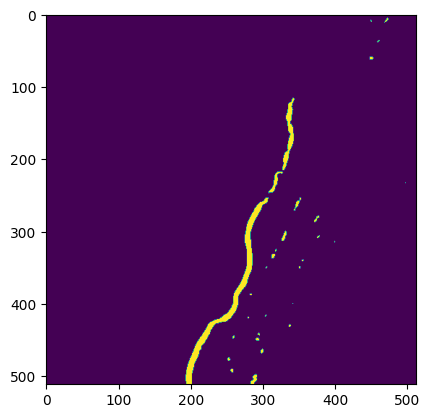

In [6]:
plt.imshow(suppressed)

In [7]:
noise_removal_threshold = 100
contours, hierarchy = cv2.findContours(suppressed, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
mask = np.zeros_like(suppressed)
for contour in contours:
    area = cv2.contourArea(contour)
    if area > noise_removal_threshold:
        cv2.fillPoly(mask, [contour], 255)

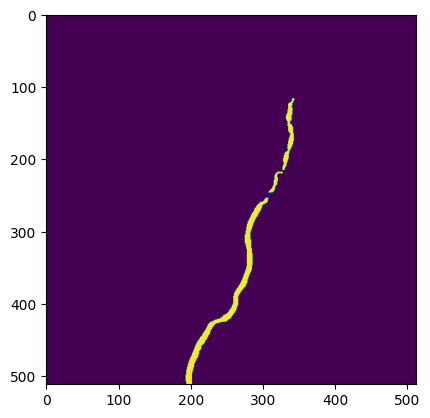

In [8]:
plt.imshow(mask)

In [9]:
# scale seems a little off the charts, rescaling down to reasonable ranges (0-1)
scaled_mag = magnitude / np.max(magnitude)

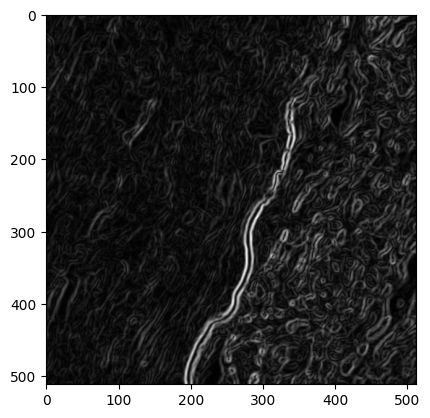

In [10]:
plt.imshow(scaled_mag, cmap='gray')

## Appears as though going through with deep learning may be a good idea
Things learned:
- make sure to double check pixel value boundaries and type so they match. i.e. range for float is 0-1 and for integers is 0-255
- it seems like just a blurred image with a minimal suppression works well for starting ground truth labels
- can even use some noise suppression techniques to make it easier
- images used for input should be split into regions

## New test: what does the ground truth look like with this algorithm

In [8]:
def generate_ground_truth(img):
    # Step 1: Gaussian filter for blurring first
    blurred = cv2.GaussianBlur(image[:,:,0], (5,5), 1)
    brightness_percentile = 2
    size = blurred.shape[0] * blurred.shape[1] # length * width
    brightness_percentile /= 100
    
    flattened_blur = blurred.flatten()
    
    perc_idx = int(size * brightness_percentile)
    
    print(size, brightness_percentile, perc_idx)
    
    brightness_threshold = np.argpartition(flattened_blur, -perc_idx)[-perc_idx:]
    brightness_threshold = brightness_threshold[np.argmin(flattened_blur[brightness_threshold])]
    brightness_threshold = flattened_blur[brightness_threshold]
    
    print(brightness_threshold)
    
    blurred[blurred < brightness_threshold] = 0
    blurred[blurred > 0] = 255
    
    noise_removal_threshold = 100
    contours, hierarchy = cv2.findContours(blurred, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    mask = np.zeros_like(blurred)
    for contour in contours:
        area = cv2.contourArea(contour)
        if area > noise_removal_threshold:
            cv2.fillPoly(mask, [contour], 255)
    
    return mask

In [6]:
files = os.listdir('../data')[:-1]
for file in files:
    image = cv2.imread('../data/' + file)
    gt_res = generate_ground_truth(image)
    cv2.imwrite('../data/ground_truth/' + file ,gt_res)
print("done!")

done!


In [9]:
filepath = '../Example Images/C-8.png'
image = cv2.imread(filepath)
result = generate_ground_truth(image)

25000000 0.02 500000
101


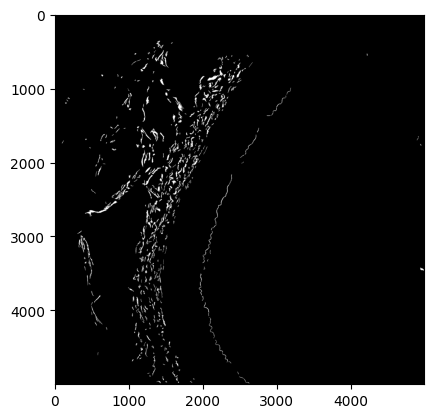

In [10]:
plt.imshow(result, cmap='gray')